In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from utils import read_ami_SPY_data

In [4]:
train_size = 200
test_size = 50
full_size = train_size + test_size
std_dev_multiplier = 1

In [5]:
data = read_ami_SPY_data()

In [6]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [7]:
features_to_delete = data.columns.tolist()

# ROC

In [8]:
for i in [2, 5, 10, 20]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

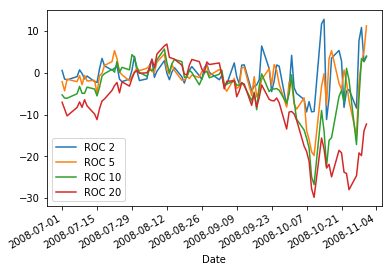

In [9]:
data['2008-07': '2008-10'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20']].plot()

# Deviation from zero-lag exponential MA

In [10]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

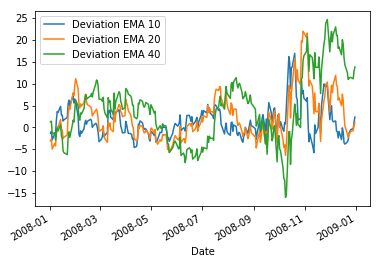

In [11]:
data['2008'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [12]:
for i, j, k in [(12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
    data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
    data[f'MACD hist ({i}, {j}, {k})'] = macdhist

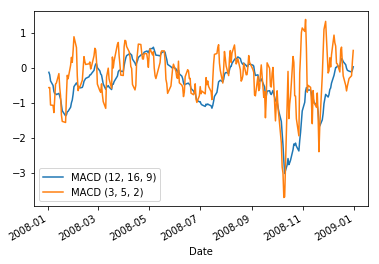

In [13]:
data['2008'][['MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

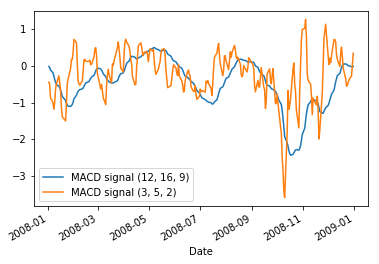

In [14]:
data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

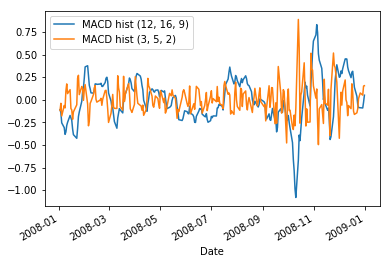

In [15]:
data['2008'][['MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [16]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

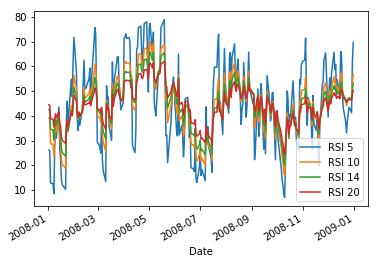

In [17]:
data['2008'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [18]:
for i, j in [(5, 10), (10, 20)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

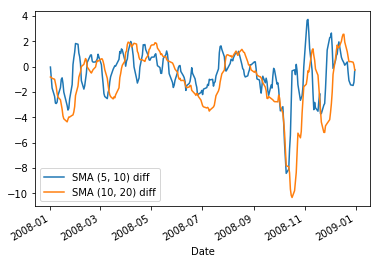

In [19]:
data['2008'][['SMA (5, 10) diff', 'SMA (10, 20) diff']].plot()

# ADX

In [20]:
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)

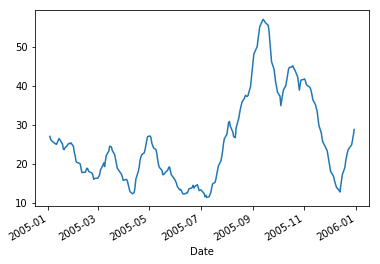

In [21]:
data['2005']['ADX 14'].plot()

# CCI

In [22]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

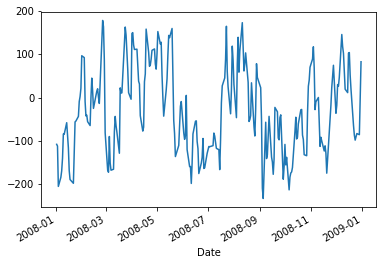

In [23]:
data['2008']['CCI 14'].plot()

# STD deviation 20

In [24]:
data['Std dev 20'] = tl.STDDEV(close, timeperiod=20)

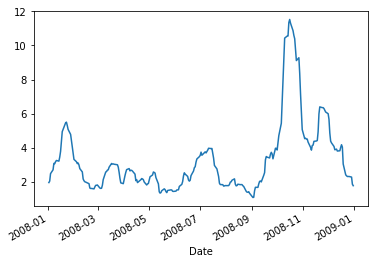

In [25]:
data['2008']['Std dev 20'].plot()

# Y target value

In [26]:
return_day = 5
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Return scaled'] = data['Return'] / (data['Return'].rolling(return_day).std().fillna(1.0))

In [27]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (12, 16, 9)","MACD signal (12, 16, 9)","MACD hist (12, 16, 9)",...,RSI 10,RSI 14,RSI 20,"SMA (5, 10) diff","SMA (10, 20) diff",ADX 14,CCI 14,Std dev 20,Return,Return scaled
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-05,-0.644864,-0.415512,-0.046339,1.243877,-1.793634,-2.853139,-0.432770,0.239577,0.315609,-0.076032,...,53.024354,53.590987,54.032658,-0.93437,0.93594,20.489020,-11.558144,1.942356,1.437181,1.254787
1999-05-06,0.175178,-0.267523,-1.595153,-0.637330,-1.750246,-3.248888,-1.433450,0.192688,0.291025,-0.098337,...,49.850643,51.333388,52.467542,-0.78906,0.76172,19.845702,-22.992688,1.940844,2.507309,1.941568
1999-05-07,0.139082,1.313321,-0.598251,0.092678,-0.453265,-2.032408,-0.610786,0.190961,0.271012,-0.080052,...,53.632405,53.898380,54.180882,-0.35781,0.67422,19.248335,-3.573762,1.942808,-0.902815,-0.575745
1999-05-10,0.256597,-1.001861,-1.658642,-1.455773,-0.508662,-2.257764,-1.461731,0.161892,0.249188,-0.087296,...,50.815811,51.947877,52.854255,-0.40313,0.54688,18.298311,-26.438913,1.888977,-0.104669,-0.076800
1999-05-11,0.509259,1.448598,-1.138434,0.184587,0.980149,-0.836615,-0.315329,0.186469,0.236644,-0.050176,...,56.009288,55.459840,55.190875,0.14062,0.37813,17.280123,55.896787,1.897725,-1.289728,-0.803775


### Features

In [28]:
feature_names = data.drop(['Return', 'Return scaled'], axis=1).columns

# Train and test Random Forest

In [29]:
def make_X_y(df):
    X = df.drop(['Return', 'Return scaled'], axis=1)
    y = df['Return']
#     y = df['Return scaled']
    ret = df['Return']
    return X, y, ret

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    ret = ret.iloc[train_size:]
    
#     extreme = y_train[-test_size:].std()*std_dev_multiplier
    extreme = y_train.std()*std_dev_multiplier
    print(f'---\nExtreme (std dev of y_train): {extreme}')
    
    X_train = pd.concat([X_train, X_train[-50:], X_train[-25:], X_train[-10:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-50:], y_train[-25:], y_train[-10:]], ignore_index=True)
    return X_train, X_test, y_train, y_test, ret, extreme

In [31]:
def to_class(val, extreme):
    if val < -extreme:
        return 'Neg'
    elif val > extreme:
        return 'Pos'
    else:
        return 'Neutral'

In [32]:
def convert_y_to_labels(y_train, y_test, extreme):
    y_train = y_train.apply(lambda val: to_class(val, extreme))
    y_test = y_test.apply(lambda val: to_class(val, extreme))
    
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)
    
    return y_train, y_test

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred):
    bad = ((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos'))
    bad_sum = -10*np.sum(bad)
    avg = ((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg'))
    avg_sum = -2*np.sum(avg)
    good = ((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg'))
    good_sum = 15*np.sum(good)
    return bad_sum + good_sum
scorer = make_scorer(custom_loss, greater_is_better=True)

In [34]:
def calculate_returns(ret, y_pred):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [35]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [36]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, ret, extreme = split_X_y(X, y, ret)
    y_train, y_test = convert_y_to_labels(y_train, y_test, extreme)
    
    params = {'n_estimators': [25,50,100],
#               'max_depth': [3,4,None],
              'max_features': [2,3,4,5],
              'min_samples_split': [2,3,4,5],
              'min_samples_leaf': [1,2,3]}
    grid = GridSearchCV(estimator=RandomForestClassifier(n_jobs=8, class_weight='balanced', max_depth=None),
                        param_grid=params, 
                        scoring=scorer)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.iloc[0].name,
        'best_params': best_params,
        'features': best_estimator.feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [37]:
test_params = []

for i in range(1800, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2006-06-30 00:00:00 to 2007-06-28 00:00:00
---
Extreme (std dev of y_train): 1.330343827053118
---
Distribution:
Neutral    178
Pos         88
Neg         19
Name: Return, dtype: int64
---
Distribution:
Neutral    32
Pos        11
Neg         7
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         7
    Neutral       0.60      0.75      0.67        32
        Pos       0.20      0.18      0.19        11

avg / total       0.43      0.52      0.47        50

---
Confusion matrix
 [[ 0  7  0]
 [ 0 24  8]
 [ 0  9  2]]
4.105952789630218 [long] + 0.0 [short] = 4.105952789630218
From 2006-09-12 00:00:00 to 2007-09-10 00:00:00
---
Extreme (std dev of y_train): 1.331820316298602
---
Distribution:
Neutral    183
Pos         69
Neg         33
Name: Return, dtype: int64
---
Distribution:
Neutral    24
Pos        15
Neg        11
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        11
    Neutral       0.70      0.58      0.64        24
        Pos       0.43      0.87      0.58        15

avg / total       0.47      0.54      0.48        50

---
Confusion matrix
 [[ 0  4  7]
 [ 0 14 10]
 [ 0  2 13]]
1.9370216069086963 [long] + 0.0 [short] = 1.9370216069086963
From 2006-11-21 00:00:00 to 2007-11-19 00:00:00
---
Extreme (std dev of y_train): 1.6865637201329116
---
Distribution:
Neutral    204
Pos         47
Neg         34
Name: Return, dtype: int64
---
Distribution:
Neutral    26
Neg        13
Pos        11
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        13
    Neutral       0.54      0.85      0.66        26
        Pos       0.22      0.18      0.20        11

avg / total       0.33      0.48      0.39        50

---
Confusion matrix
 [[ 0 10  3]
 [ 0 22  4]
 [ 0  9  2]]
-6.847848752885987 [long] + 0.0 [short] = -6.847848752885987
From 2007-02-06 00:00:00 to 2008-02-01 00:00:00
---
Extreme (std dev of y_train): 1.9519533219403862
---
Distribution:
Neutral    192
Neg         54
Pos         39
Name: Return, dtype: int64
---
Distribution:
Neutral    22
Neg        17
Pos        11
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      0.12      0.18        17
    Neutral       0.45      0.86      0.59        22
        Pos       0.33      0.09      0.14        11

avg / total       0.41      0.44      0.35        50

---
Confusio

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
    Neutral       0.62      0.88      0.73        32
        Pos       0.00      0.00      0.00         9

avg / total       0.40      0.56      0.47        50

---
Confusion matrix
 [[ 0  9  0]
 [ 4 28  0]
 [ 1  8  0]]
0.0 [long] + -13.372160450734684 [short] = -13.372160450734684
From 2008-04-16 00:00:00 to 2009-04-13 00:00:00
---
Extreme (std dev of y_train): 4.873580518096731
---
Distribution:
Neutral    217
Neg         41
Pos         27
Name: Return, dtype: int64
---
Distribution:
Neutral    29
Pos        11
Neg        10
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        10
    Neutral       0.55      0.72      0.63        29
        Pos       0.40      0.18      0.25        11

avg / total       0.41      0.46      0.42        50

---
Confusi

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.92      1.00      0.96        46
        Pos       0.00      0.00      0.00         4

avg / total       0.85      0.92      0.88        50

---
Confusion matrix
 [[46  0]
 [ 4  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2008-09-08 00:00:00 to 2009-09-02 00:00:00
---
Extreme (std dev of y_train): 5.696009197383122
---
Distribution:
Neutral    227
Neg         32
Pos         26
Name: Return, dtype: int64
---
Distribution:
Neutral    47
Pos         3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.96      1.00      0.98        47
        Pos       0.00      0.00      0.00         3

avg / total       0.90      0.94      0.92        50

---
Confusion matrix
 [[ 0  0  0]
 [ 0 47  0]
 [ 1  2  0]]
0.0 [long] + -6.74832709538391 [short] = -6.74832709538391
From 2008-11-17 00:00:00 to 2009-11-12 00:00:00
---
Extreme (std dev of y_train): 4.325605059955523
---
Distribution:
Neutral    213
Pos         46
Neg         26
Name: Return, dtype: int64
---
Distribution:
Neutral    46
Pos         4
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.92      0.96      0.94        46
        Pos       0.00      0.00      0.00         4

avg / total       0.84      0.88      0.86        50

---
Confusion matrix
 [[ 0  0  0]
 [ 1 44  1]
 [ 0  4  0]]
-1.6632211990227352 [long] + -2.324278913469624 [short] = -3.9875001124923592
From 2009-01-30 00:00:00 to 2010-01-27 00:00:00
---
Extreme (std dev of y_train): 3.6774635042396224
---
Distribution:
Neutral    212
Pos         51
Neg         22
Name: Return, dtype: int64
---
Distribution:
Neutral    48
Neg         2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.96      0.90      0.92        48
        Pos       0.00      0.00      0.00         0

avg / total       0.92      0.86      0.89        50

---
Confusion matrix
 [[ 0  2  0]
 [ 2 43  3]
 [ 0  0  0]]
1.2548993055468305 [long] + -3.4017215401323186 [short] = -2.146822234585488
From 2009-04-14 00:00:00 to 2010-04-09 00:00:00
---
Extreme (std dev of y_train): 2.5591406308046585
---
Distribution:
Neutral    202
Pos         46
Neg         37
Name: Return, dtype: int64
---
Distribution:
Neutral    41
Pos         6
Neg         3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.92      0.85      0.89        41
        Pos       0.33      0.67      0.44         6

avg / total       0.80      0.78      0.78        50

---
Confusion matrix
 [[ 0  1  2]
 [ 0 35  6]
 [ 0  2  4]]
9.263258433091545 [long] + 0.0 [short] = 9.263258433091545
From 2009-06-24 00:00:00 to 2010-06-21 00:00:00
---
Extreme (std dev of y_train): 2.2703539645473416
---
Distribution:
Neutral    202
Pos         57
Neg         26
Name: Return, dtype: int64
---
Distribution:
Neutral    22
Neg        18
Pos        10
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.06      0.10        18
    Neutral       0.54      0.59      0.57        22
        Pos       0.39      0.90      0.55        10

avg / total       0.44      0.46      0.39        50

---
Confusion 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.88      1.00      0.94        44
        Pos       0.00      0.00      0.00         4

avg / total       0.77      0.88      0.82        50

---
Confusion matrix
 [[ 0  2  0]
 [ 0 44  0]
 [ 0  4  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2010-01-28 00:00:00 to 2011-01-24 00:00:00
---
Extreme (std dev of y_train): 2.5604335762934096
---
Distribution:
Neutral    206
Pos         41
Neg         38
Name: Return, dtype: int64
---
Distribution:
Neutral    47
Pos         3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       1.00      0.87      0.93        47
        Pos       0.00      0.00      0.00         3

avg / total       0.94      0.82      0.88        50

---
Confusion matrix
 [[ 0  0  0]
 [ 4 41  2]
 [ 3  0  0]]
0.5990189578428673 [long] + -8.769247060631681 [short] = -8.170228102788814
From 2010-04-12 00:00:00 to 2011-04-05 00:00:00
---
Extreme (std dev of y_train): 2.4942679298097308
---
Distribution:
Neutral    224
Pos         32
Neg         29
Name: Return, dtype: int64
---
Distribution:
Neutral    43
Pos         4
Neg         3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.95      0.81      0.88        43
        Pos       0.20      0.25      0.22         4

avg / total       0.83      0.72      0.77        5

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00        20
    Neutral       0.26      0.92      0.40        12
        Pos       0.86      0.33      0.48        18

avg / total       0.37      0.34      0.27        50

---
Confusion matrix
 [[ 0 20  0]
 [ 0 11  1]
 [ 0 12  6]]
20.05911062218344 [long] + 0.0 [short] = 20.05911062218344
From 2010-11-11 00:00:00 to 2011-11-07 00:00:00
---
Extreme (std dev of y_train): 2.5878400253235316
---
Distribution:
Neutral    192
Neg         47
Pos         46
Name: Return, dtype: int64
---
Distribution:
Neutral    30
Pos        13
Neg         7
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         7
    Neutral       0.62      0.93      0.75        30
        Pos       1.00      0.08      0.14        13

avg / total       0.63      0.58      0.49        50

---
Confusion 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         8
    Neutral       0.70      0.91      0.79        35
        Pos       0.00      0.00      0.00         7

avg / total       0.49      0.64      0.55        50

---
Confusion matrix
 [[ 0  8  0]
 [ 3 32  0]
 [ 1  6  0]]
0.0 [long] + -9.054786865122555 [short] = -9.054786865122555
From 2011-04-06 00:00:00 to 2012-04-02 00:00:00
---
Extreme (std dev of y_train): 3.282605416956594
---
Distribution:
Neutral    212
Pos         38
Neg         35
Name: Return, dtype: int64
---
Distribution:
Neutral    48
Pos         1
Neg         1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.96      1.00      0.98        48
        Pos       0.00      0.00      0.00         1

avg / total       0.92      0.96      0.94        50

---
Confusion matrix
 [[ 0  1  0]
 [ 0 48  0]
 [ 0  1  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2011-06-17 00:00:00 to 2012-06-13 00:00:00
---
Extreme (std dev of y_train): 3.25616272941964
---
Distribution:
Neutral    224
Pos         31
Neg         30
Name: Return, dtype: int64
---
Distribution:
Neutral    45
Neg         4
Pos         1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
    Neutral       0.93      0.31      0.47        45
        Pos       0.03      1.00      0.06         1

avg / total       0.84      0.30      0.42        50

---
Confusion matrix
 [[ 0  1  3]
 [ 5 14 26

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.82      0.98      0.89        41
        Pos       0.00      0.00      0.00         8

avg / total       0.67      0.80      0.73        50

---
Confusion matrix
 [[ 0  1  0]
 [ 1 40  0]
 [ 0  8  0]]
0.0 [long] + -0.34515678930748805 [short] = -0.34515678930748805
From 2011-11-08 00:00:00 to 2012-11-06 00:00:00
---
Extreme (std dev of y_train): 2.1661967280980248
---
Distribution:
Neutral    208
Pos         45
Neg         32
Name: Return, dtype: int64
---
Distribution:
Neutral    38
Neg         9
Pos         3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
    Neutral       0.72      0.82      0.77        38
        Pos       0.00      0.00      0.00         3

avg / total       0.55      0.62      0.58        50

---
Conf

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.87      0.95      0.91        41
        Pos       0.60      0.43      0.50         7

avg / total       0.79      0.84      0.81        50

---
Confusion matrix
 [[ 0  2  0]
 [ 0 39  2]
 [ 0  4  3]]
8.562441073703608 [long] + 0.0 [short] = 8.562441073703608
From 2013-04-04 00:00:00 to 2014-03-31 00:00:00
---
Extreme (std dev of y_train): 1.5036491315814817
---
Distribution:
Neutral    198
Pos         60
Neg         27
Name: Return, dtype: int64
---
Distribution:
Neutral    31
Pos        10
Neg         9
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      0.33      0.43         9
    Neutral       0.69      0.65      0.67        31
        Pos       0.38      0.60      0.46        10

avg / total       0.61      0.58      0.58        50

---
Confusion 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

    Neutral       0.98      1.00      0.99        49
        Pos       0.00      0.00      0.00         1

avg / total       0.96      0.98      0.97        50

---
Confusion matrix
 [[49  0]
 [ 1  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2014-08-22 00:00:00 to 2015-08-19 00:00:00
---
Extreme (std dev of y_train): 1.7054841116149457
---
Distribution:
Neutral    230
Pos         30
Neg         25
Name: Return, dtype: int64
---
Distribution:
Neutral    38
Neg         9
Pos         3
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         9
    Neutral       0.78      0.84      0.81        38
        Pos       0.50      0.33      0.40         3

avg / total       0.62      0.66      0.64        50

---
Confusion matrix
 [[ 0  9  0]
 [ 5 32  1]
 [ 2  0  1]]
3.693520611310097 [long] + -10.349754084724559 [short]

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.96      0.98      0.97        48
        Pos       0.00      0.00      0.00         2

avg / total       0.92      0.94      0.93        50

---
Confusion matrix
 [[ 0  0  0]
 [ 1 47  0]
 [ 0  2  0]]
0.0 [long] + -1.1545677586953351 [short] = -1.1545677586953351
From 2015-08-20 00:00:00 to 2016-08-16 00:00:00
---
Extreme (std dev of y_train): 2.0884069554739666
---
Distribution:
Neutral    219
Pos         40
Neg         26
Name: Return, dtype: int64
---
Distribution:
Neutral    41
Pos         6
Neg         3
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
    Neutral       0.82      1.00      0.90        41
        Pos       0.00      0.00      0.00         6

avg / total       0.67      0.82      0.74        50

---
Confusion matrix
 [[ 0  3  0]
 [ 0 41  0]
 [ 0  6  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2015-10-30 00:00:00 to 2016-10-26 00:00:00
---
Extreme (std dev of y_train): 1.9096987022051701
---
Distribution:
Neutral    224
Pos         35
Neg         26
Name: Return, dtype: int64
---
Distribution:
Neutral    48
Neg         2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.91      0.42      0.57        48
        Pos       0.00      0.00      0.00         0

avg / total       0.87      0.40      0.55        50

---
Confusion matrix
 [[ 0  2  0]
 [ 8 20 20]
 [ 0  0  0]]
-4.2651798205382345 [long] + -1.8054489508548155 [short] = -6.07062877139305
From 2016-01-13 00:00:00 to 2017-01-09 00:00:00
---
Extreme (std dev of y_train): 1.5466152696026183
---
Distribution:
Neutral    224
Pos         34
Neg         27
Name: Return, dtype: int64
---
Distribution:
Neutral    37
Pos        11
Neg         2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
    Neutral       0.76      1.00      0.86        37
        Pos       1.00      0.09      0.17        11

avg / total       0.78      0.76      0.67        50

---
Confusion matrix
 [[ 0  2  0]
 [ 0 37  0]
 [ 0 10  1]]
3.1090677348871054 [long] + 0.0 [short] = 3.1090677348871054
From 2016-03-28 00:00:00 to 2017-03-22 00:00:00
---
Extreme (std dev of y_train): 1.3149281080439499
---
Distribution:
Neutral    214
Pos         48
Neg         23
Name: Return, dtype: int64
---
Distribution:
Neutral    36
Pos         8
Neg         6
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         6
    Neutral       0.72      1.00      0.84        36
        Pos       0.00      0.00      0.00         8

avg / total       0.52      0.72      0.60        50

---
Confusion matrix
 [[ 0  6  0]
 [ 0 36  0]
 [ 0  8  0]]
0.0 [long] + 0.0 [short] = 0.0
From 2016-06-07 00:00:00 to 2017-06-02 00:00:00
---
Extreme (std dev of y_train): 1.275657136726952
---
Distribution:
Neutral    202
Pos         42
Neg         41
Name: Return, dtype: int64
---
Distribution:
Neutral    42
Pos         7
Neg         1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.82      0.88      0.85        42
        Pos       0.00      0.00      0.00         7

avg / total       0.69      0.74      0.71        50

---
Confusion matrix
 [[ 0  1  0]
 [ 1 37  

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
    Neutral       0.82      0.82      0.82        39
        Pos       0.25      0.18      0.21        11

avg / total       0.69      0.68      0.69        50

---
Confusion matrix
 [[ 0  0  0]
 [ 1 32  6]
 [ 2  7  2]]
5.611770950406669 [long] + -2.3272764912851907 [short] = 3.284494459121478
From 2017-01-10 00:00:00 to 2018-01-05 00:00:00
---
Extreme (std dev of y_train): 0.8187632578205195
---
Distribution:
Neutral    199
Pos         70
Neg         16
Name: Return, dtype: int64
---
Distribution:
Neutral    29
Pos        20
Neg         1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
    Neutral       0.65      0.83      0.73        29
        Pos       0.78      0.35      0.48        20

avg / total       0.69      0.62      0.61        50

In [38]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [39]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [40]:
params.sort_values('Sum of return', ascending=False)

,max_features,min_samples_leaf,min_samples_split,n_estimators,Sum of return,Accuracy
2007-11-20,5,2,2,25,87.878289,0.40
2013-04-04,3,2,3,25,29.766955,0.58
2014-11-03,2,3,3,25,23.129946,0.48
2015-03-30,2,2,3,25,20.771451,0.76
2010-09-01,5,1,4,25,20.059111,0.34
2013-08-26,4,3,5,25,16.966217,0.64
2012-11-07,5,2,3,25,14.280000,0.62
2011-06-17,5,3,3,25,12.545302,0.30
2007-02-06,4,3,3,25,11.055800,0.44
2007-09-11,3,3,2,25,10.944603,0.42


In [41]:
params.describe()

,max_features,min_samples_leaf,min_samples_split,n_estimators,Sum of return,Accuracy
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,3.444444,2.314815,3.277778,35.648148,3.867159,0.651111
std,1.192218,0.772745,1.106016,19.182497,15.348389,0.167632
min,2.000000,1.000000,2.000000,25.000000,-22.518467,0.300000
25%,2.000000,2.000000,2.000000,25.000000,-3.111373,0.525000
50%,3.000000,2.500000,3.000000,25.000000,1.017823,0.640000
75%,5.000000,3.000000,4.000000,50.000000,8.932996,0.760000
max,5.000000,3.000000,5.000000,100.000000,87.878289,0.980000


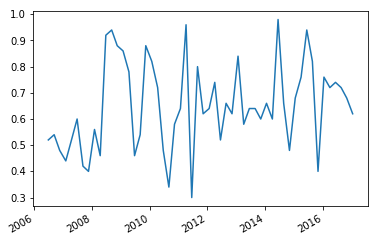

In [42]:
params['Accuracy'].plot()

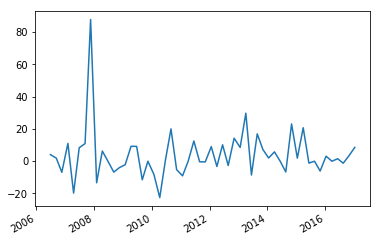

In [43]:
params['Sum of return'].plot()

### Feature importances

In [45]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [46]:
features.idxmax(axis=1).value_counts()

ADX 14                     12
SMA (10, 20) diff           8
Std dev 20                  6
MACD signal (12, 16, 9)     5
ROC 20                      4
MACD (12, 16, 9)            4
Deviation EMA 40            4
RSI 20                      3
RSI 10                      2
MACD signal (3, 5, 2)       1
MACD hist (12, 16, 9)       1
CCI 14                      1
ROC 10                      1
ROC 5                       1
SMA (5, 10) diff            1
dtype: int64

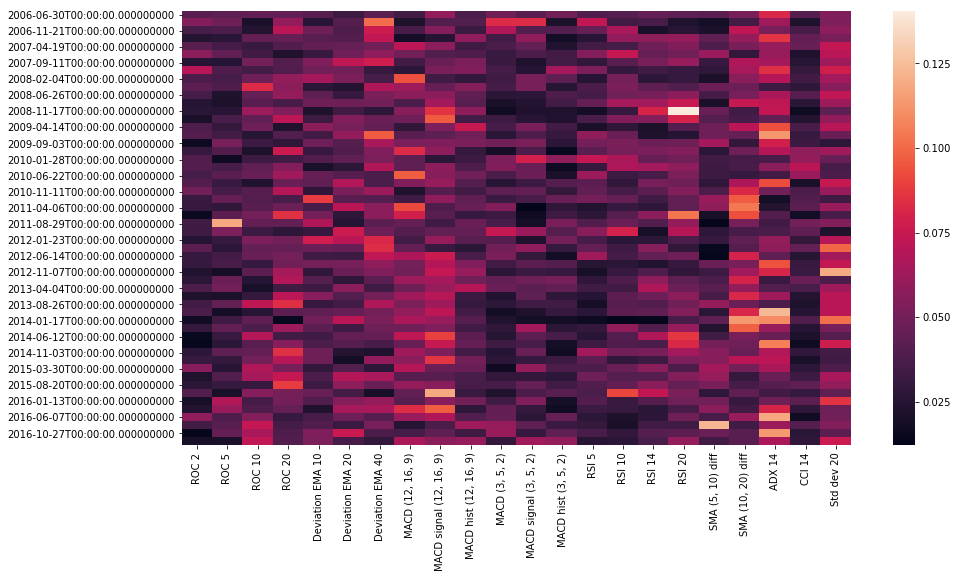

In [47]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


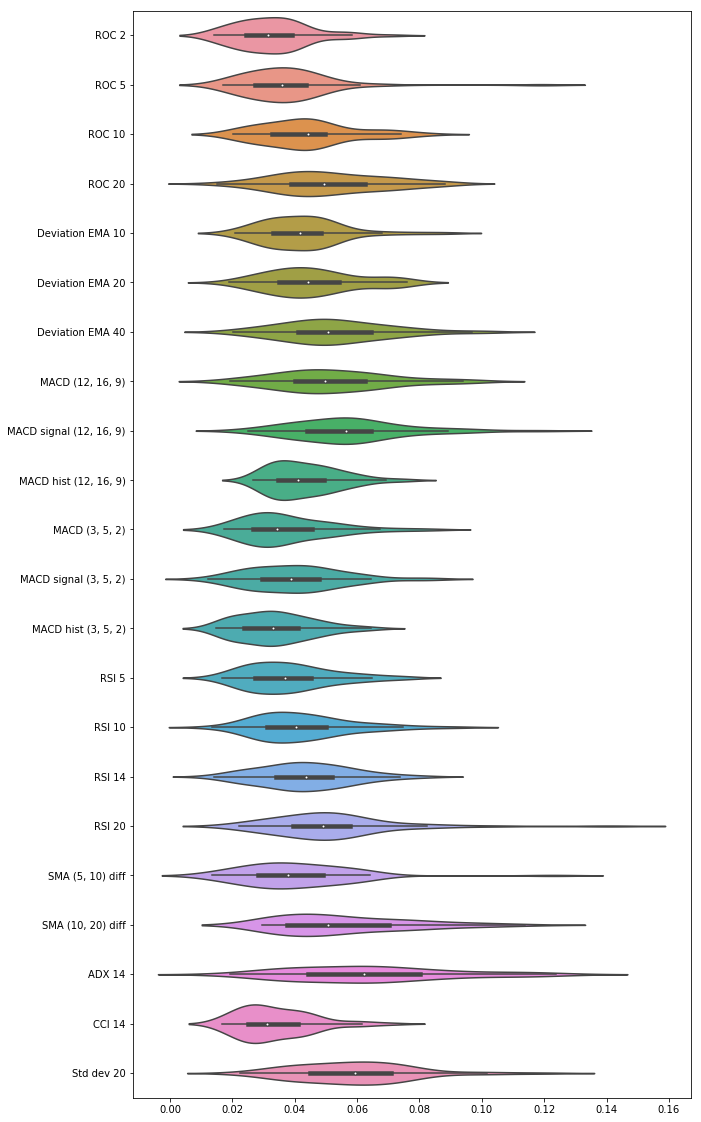

In [52]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')